In [83]:
#!pip install pandas -i https://simple.baidu.com/pypi/simple
    

Looking in indexes: https://simple.baidu.com/pypi/simple


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import csv
from scipy import stats
from itertools import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,f_classif,SelectPercentile
from sklearn.linear_model import Lasso,lasso_path,LassoCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score
from scipy.stats import sem
from pandas import Series,DataFrame
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.externals import joblib
%matplotlib inline
sns.set_style('white')
plt.rcParams['figure.dpi'] = 300
plt.show()

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [10]:
#!pip list

In [71]:
#函数功能：输入路径和分类名，返回训练矩阵
def read_file(path):
    #df = pd.read_csv(path,index_col=0,encoding='gbk',error_bad_lines=False)  
    df = pd.read_csv(path,index_col=0,encoding='gbk',error_bad_lines=False,skip_blank_lines=True)


#   new_df = new_df.replace(u'是',u'0')
 

    X = df.iloc[:,1:]#1开始计数，－2
    y = df.iloc[:,0]  #1开始计数，－2
    
    #ss = StandardScaler().fit(X)
    #X_std = ss.transform(X)  #为了数据归一化（使特征数据方差为1，均值为0）
    #X = DataFrame(X_std,index=X.index,columns=X.columns)
    
    features = [X.columns]
    
    print (len(X))  #打印X行数
    print (len(y))  #打印y行数
    print (features[0]) #打印X的列名，确认第一个列名是否正确
    print (y.describe()) #打印Y的信息，确认Y是否正确
    return X,y,features

In [72]:
#函数功能：按照比例随机分组，标准化，正则化
def train_test(X,y,random):
    grouped = y.groupby(y)
    uniquekeys=[]
    data = []
    for k,g in grouped:
        groups=list(g)
        uniquekeys=k
    y0 = grouped.get_group(0)
    y1 = grouped.get_group(1)
    X0 = DataFrame(X,index=y0.index)
    X1 = DataFrame(X,index=y1.index)
    
    X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=.2,random_state=random)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=.2,random_state=random)
    
    X_train = pd.concat([X_train0,X_train1],axis=0,join='inner')
    X_test = pd.concat([X_test0,X_test1],axis=0,join='inner')
    y_train = pd.concat([y_train0,y_train1],axis=0,join='inner')
    y_test = pd.concat([y_test0,y_test1],axis=0,join='inner')

    y_train = np.array(y_train, dtype = int)
    y_test = np.array(y_test, dtype = int)
    
    ss = StandardScaler().fit(X_train)
    X_train_std = ss.transform(X_train)
    X_train = DataFrame(X_train_std,index=X_train.index,columns=X_train.columns)
    
    X_test_std = ss.transform(X_test)
    X_test = DataFrame(X_test_std,index=X_test.index,columns=X_test.columns)
    
    return X_train,y_train,X_test,y_test

In [73]:
def move_lowvariance(X,y):
    sel = VarianceThreshold(threshold=(.08 * (1 - .08)))
    sel_X = sel.fit_transform(X)
    result = sel.get_support()
    features = X.columns
    features_split = []
    sel_features = []
    sel_features_split = []
    first = []
    sel_first = []
    for index, item in enumerate(features):
        item_split = item.split('_')
        features_split.append(item_split)
        first.append(item_split[0])    
        if result[index]:
            sel_features.append(item)
            sel_features_split.append(item_split)
            sel_first.append(item_split[0])
    print(("features reduced from {0} to {1}".format(len(features),len(sel_features))))
    X = X[sel_features]
    y = y
    features = sel_features
    return X,y,features

In [74]:
# 功能：输入特征矩阵和因变量，输出筛选后的特征矩阵，因变量，筛选的特征名称
def select_KBest(X,y):
    sel = SelectKBest(f_classif,k = 'all').fit(X,y)
    scores = sel.scores_
    pvalue = sel.pvalues_
    features = X.columns
    result = sel.get_support()
    sort_features = []
    for index, item in enumerate(features):
        if result[index]:
            sort_features.append(item)
    named_scores = zip(features, scores, pvalue) 
    sel_scores = list(filter(lambda row: row[2] < 0.05, named_scores))#筛选特征
    sorted_scores = sorted(sel_scores,key = lambda z:z[1],reverse=True) 
    name=['name','scores','pvalue']
    sel_k=pd.DataFrame(columns=name,data=sorted_scores)#数据有三列，列名分别为
    num=len(sel_k)
    print(num)
    sel_k.to_csv(in_path+'sel_k.csv',encoding='gbk')#储存筛选的特征
    X = X[sel_k['name']]
    y =y
    print(("features reduced from {0} to {1}".format(len(features),num)))
    return X,y,sel_features

In [75]:
def lasso_filter(X,y,cv):   
    model = LassoCV(cv=cv,max_iter=3000).fit(X,y)
    w0=model.intercept_
    selected =  -np.log10(model.alpha_)
    m_log_alphas = -np.log10(model.alphas_)
    features = X.columns
    coef = pd.Series(model.coef_, index = features)
    sel_coef = coef[coef!=0]  
    sel_features = sel_coef.index
    X = X[sel_features]    
#     打印最佳alpha值  
    print(("features reduced from {0} to {1}".format(len(features),len(sel_features))))
    print("最佳alpha值为%.5f，-log10(alpha)为%.5f"%((model.alpha_,selected)))          
    print("截距=",w0)   
# 均方误差路径图
    plt.figure()
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.legend()
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.savefig(in_path+"Mean square error.png")
    plt.show() 
   
#     系数解路径图 用坐标下降计算
    eps = 1e-2 # the smaller it is the longer is the path alpha_min / alpha_max = 1e-2
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)
    plt.figure()
    ax = plt.gca()
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    for coef_l, c in zip(coefs_lasso,colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso Path')
    plt.axis('tight')
    plt.savefig(in_path+"Lasso Path.png")
    plt.show()
    
#     特征柱状图
    mp_coef = pd.concat([sel_coef.sort_values()])
    mp_coef.plot(kind = "barh",color='b')
    plt.yticks(fontsize=3)
    plt.title("Coefficients in the Lasso Model")
    plt.subplots_adjust(left=0.25)
    plt.savefig(in_path+"Coefficients in the Lasso Model.png")
#    表格导出
    X.to_csv(in_path+'lasso.csv')
    mp_coef.to_csv(in_path+'lasso-coef.csv')      
    return X,y,sel_features    

In [76]:
def matrix_report(y_test,y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    TN = matrix[1,1]
    TP = matrix[0,0]
    FN = matrix[0,1]
    FP = matrix[1,0]
    sensitivity = TP/float(FN+TP)
    specificity = TN/float(TN+FP)
    precision =  (TP+TN)/float(TN+FN+TP+FP)
    print (matrix)
    print('sensitivity = ',sensitivity) 
    print( 'specificity = ',specificity)
    print( 'precision = ',precision)

In [77]:
# 输入：真实值（0/1），预测值（0/1），预测概率；输出：ROC曲线、最佳阈值、AUC和95%CI、方差
def auc_report(y_test,y_pred,y_pred_prob):
#     选择阳性的标签（0/1）
    fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob, pos_label=1)
    auc_result = roc_auc_score(y_test, y_pred_prob)
    
#     cut-off point 
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i),'yd' : pd.Series(tpr-fpr, index=i), 'threshold' : pd.Series(thresholds, index=i)})
#     方法1：youdeng指数
#     roc_t = roc.ix[(-roc.yd).argsort()[:1]]   
#     方法2：(tpr-(1-fpr)指数
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    
    threshold_value = roc_t['threshold'].values
    
    #     figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.plot(fpr, tpr, color='b',label='area under AUC is {:0.2f}'.format(auc_result))
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    #plt.title('ROC curve for T2 classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    
#     输出最佳阈值、AUC和95%CI、方差
    print('tpr-(1-fpr)指数：threshold_value = ',threshold_value) 
    print ('auc = ',auc_result)

In [78]:
 def CI_ROC (y_true,y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true, dtype = int)
    n_bootstraps = 1000
    rng_seed = 42 
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    CI_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    CI_upper = sorted_scores[int(0.95 * len(sorted_scores))] 
    SD = np.std(sorted_scores)
    print (" 95%CI: [{:0.2f} - {:0.2f}]".format(CI_lower,CI_upper))
    print ('SD = ',SD)
    return CI_lower, CI_upper

In [79]:
import copy

def model_training(X,y,clf,cv):

    X_index = X.index
    X_index = DataFrame(X_index,columns=['X_index'])
    X = np.array(X) 
    yprob = DataFrame()

    cv = StratifiedKFold(n_splits=cv)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    
    clfs = []
    
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        pred_ = clf.fit(X[train], y[train]).predict(X[test])
        
        clfs.append(copy.deepcopy(clf))
        
    # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        matrix = confusion_matrix(y[test],pred_)
        print ('第 %d 折  matrix result:'%i)
        print (matrix)
        yprobabi = DataFrame(probas_,index = test, columns = ['y_proba0','y_proba1'])
        y_true = DataFrame(y[test],index = test,columns = ['y_true'])
        y_pred = DataFrame(pred_,index = test,columns = ['y_pred'])
        
        yprobabi = pd.concat([y_true,y_pred,yprobabi],axis=1,join='inner',ignore_index = False)
        yprob = yprob.append(yprobabi)
        y_proba = yprob.sort_index()
    #y_true_pred = pd.concat([X_index,y_proba],axis=1,join='inner',ignore_index = True)
    y_train_all=y_proba ['y_true']
    y_pred_prob_all=y_proba ['y_proba1']    
    y_proba.to_csv(in_path+'C_yTrain_true_pred_cli.csv')
    

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    print (r'mean_auc=%0.2f $\pm$ %0.2f'%(mean_auc, std_auc))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right",fontsize = 'x-small')
    plt.show()
   
    model = pickle.dumps(clfs[0])
    return model,mean_auc,y_train_all,y_pred_prob_all

In [80]:
def model_testing(model,X_test,y_test):

    X_index = list(X_test.index)
    X_index = DataFrame(X_index,columns=['X_index'])
    
    clf = pickle.loads(model)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    print (clf.classes_)
    
    y_pred_prob = DataFrame(y_pred_prob,index = X_index, columns = ['y_proba0'])
    # y_pred_prob = DataFrame(y_pred_prob,index = X_index, columns = ['y_proba0'])
    y_test = DataFrame(y_test,index = X_index,columns = ['y_true'])
    y_pred = DataFrame(y_pred,index = X_index,columns = ['y_pred'])
    
    yTest_true_pred = pd.concat([y_test,y_pred,y_pred_prob],axis=1,join='inner',ignore_index = True)
    
    
    yTest_true_pred.to_csv(in_path+'C_yTest_true_pred.csv')
    return  y_test,y_pred,y_pred_prob

In [81]:
import numpy as np
import csv
import pandas as pd

def read_csv_self(file):
    csv_file = open(file, 'r')
    next(csv_file) # 跳过第一行
    f = csv.reader(csv_file)
    subject_list = []
    slice_index = []
    features = []
    labels = []
    for row in f:
        subject_list.append(row[0])
        slice_index.append(int(row[1]))
        features.append(list(map(float, row[2:])))
        if 'PD' in row[0]:
            labels.append(1)
        else:
            labels.append(0)
    features = np.array(features)
    print(len(subject_list), len(slice_index), features.shape)
    return pd.DataFrame(subject_list), pd.DataFrame(slice_index), pd.DataFrame(features), pd.DataFrame(labels)

In [82]:
in_path='/home/work/moyan01/ML/浙2/2D_DL/'
path ='resnet-2d_new.csv'

data_clean = read_file(path)
X = data[0]
y = data[1]

IndexError: list index out of range

In [33]:
#features

In [43]:
random = 61
data = train_test(X,y,random)
X = data[0]
y = data[1]
X_test = data[2]
y_test = data[3]
print (X)

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
#逻辑回归
clf = LogisticRegression(penalty='l2',class_weight='balanced',solver='newton-cg')
# clf = LogisticRegression(penalty='l1',class_weight='balanced')
# clf = LogisticRegression()

#svm
# clf = svm.SVC(kernel='linear',probability=True)
# clf = svm.SVC(probability=True)
# clf = svm.SVC(kernel='poly',C=2,probability=True)
# clf = svm.SVC(kernel='rbf',C=0.1,probability=True)

# DecisionTree
# clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=257, max_leaf_nodes=None, presort=False)
# clf = tree.DecisionTreeClassifier(class_weight='balanced',splitter='random',random_state=100)
# clf = tree.DecisionTreeClassifier(class_weight='balanced',splitter='random',criterion='entropy',random_state=10)
# clf = tree.DecisionTreeClassifier(class_weight='balanced')

# RandomForest
# clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=127, verbose=0, warm_start=False, class_weight=None)
# clf = RandomForestClassifier(n_estimators=50,class_weight='balanced',criterion='entropy',random_state=5)
#clf = RandomForestClassifier(class_weight='balanced')
#clf = RandomForestClassifier(n_estimators=50)

# KNeighbors
# clf = KNeighborsClassifier(n_neighbors=6, leaf_size=30,weights='uniform',algorithm='auto',p=2)
# clf = KNeighborsClassifier(n_neighbors=6,p=2,algorithm='brute',weights ='distance')
# clf = KNeighborsClassifier(n_neighbors=4,p=2)
# clf = KNeighborsClassifier()

# MLP
# clf = MLPClassifier(hidden_layer_sizes=(4, 20))


# for j in range(3,10):
#     X_lasso,y_lasso,features_lasso = lasso_filter(X,y,j)
#     X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)
# #     X_test_feature.to_csv('C:\\liang\\C_lasso_Test.csv') #需要可导出
#     for i in range(3,10):
#         print('cv_lasso=',j) 
#         print ('cv_ml = ',i)
#         model,mean_auc = model_training(X_lasso,y_lasso,clf,i)
#         y_pred_train,y_proba_train = model_testing(model,X_test_feature,y_test)
#         auc_report(y_test,y_pred_train,y_proba_train)
#         print('#########################################')


In [ ]:
X_lasso,y_lasso,features_lasso = lasso_filter(X,y,10)
X_test_feature = DataFrame(X_test,index=X_test.index,columns=X_lasso.columns)
X_test_feature.to_csv(in_path+'lasso_Test.csv')

In [ ]:
model,mean_auc,y_true,y_pred = model_training(X_lasso,y_lasso,clf,5)
CI_ROC (y_true,y_pred)

In [ ]:
df = pd.read_csv('/home/work/moyan01/ML/浙2/2D_DL/C_yTrain_true_pred_cli.csv',index_col=0,encoding='gbk')


In [50]:
y_true=df.iloc[:,0]
y_pred=df.iloc[:,1]

In [51]:
1/1.7222222222222223

0.5806451612903225

In [52]:
matrix_report(y_true,y_pred)

[[134  41]
 [ 24  30]]
sensitivity =  0.7657142857142857
specificity =  0.5555555555555556
precision =  0.7161572052401747


[0 1]


/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


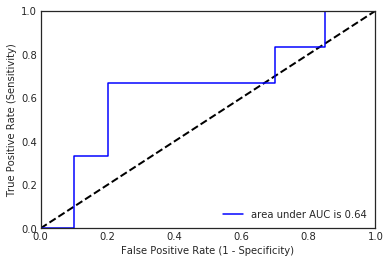

tpr-(1-fpr)指数：threshold_value =  [0.45691227]
auc =  0.6416666666666666


In [53]:
y_test,y_pred_test,y_proba_test = model_testing(model,X_test_feature,y_test)
# CI_ROC (y_test,y_proba_test)
auc_report(y_test,y_pred_test,y_proba_test)

In [54]:
# def rad_score(feature,coef,path_in):
#     feature_name = feature.columns
#     coefficient = coef[feature_name]
#     print '*********************************'
#     radscore = np.dot(feature , coefficient)
#     radscore = pd.DataFrame(radscore,index = feature.index)
#     radscore.columns = ['fea_score']
#     print radscore
#     print '##############feature#############'
#     radscore.to_csv(path_in+'radscore.csv')
#     return radscore

In [56]:
df_rad= pd.read_csv('/home/work/moyan01/ML/lasso_Test.csv',index_col=0,encoding='gbk')
df_cli= pd.read_csv('/home/work/moyan01/ML/lasso_Test.csv',index_col=0,encoding='gbk')
#df_all=pd.read_csv('/home/work/moyan01/ML/zunyi_shengyi_cli_rad_hefenji.csv',index_col=0,encoding='gbk')

In [57]:
in_path='/home/work/moyan01/ML/'  

In [58]:
list_rad=df_rad.columns.values.tolist()
list_cli=df_cli.columns.values.tolist()
list_label=['label']
list_all=list_label+list_cli

In [59]:
len(set(list_rad).difference(set(df_all.columns)))

NameError: name 'df_all' is not defined

In [123]:
df_new=df_all[list_all]
X = df_new.iloc[:,1:]#1开始计数，－2
Y = df_new.iloc[:,0] 
Y= np.array(Y, dtype = int)
ss = StandardScaler().fit(X)
X_std = ss.transform(X)
X = DataFrame(X_std,index=X.index,columns=X.columns)

In [104]:
Y

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0])

第 1 折  matrix result:
[[25 14]
 [ 4  8]]
第 2 折  matrix result:
[[37  2]
 [ 9  3]]
第 3 折  matrix result:
[[27 12]
 [ 5  7]]
第 4 折  matrix result:
[[24 15]
 [ 3  9]]
第 5 折  matrix result:
[[34  5]
 [ 6  6]]
mean_auc=0.71 $\pm$ 0.03


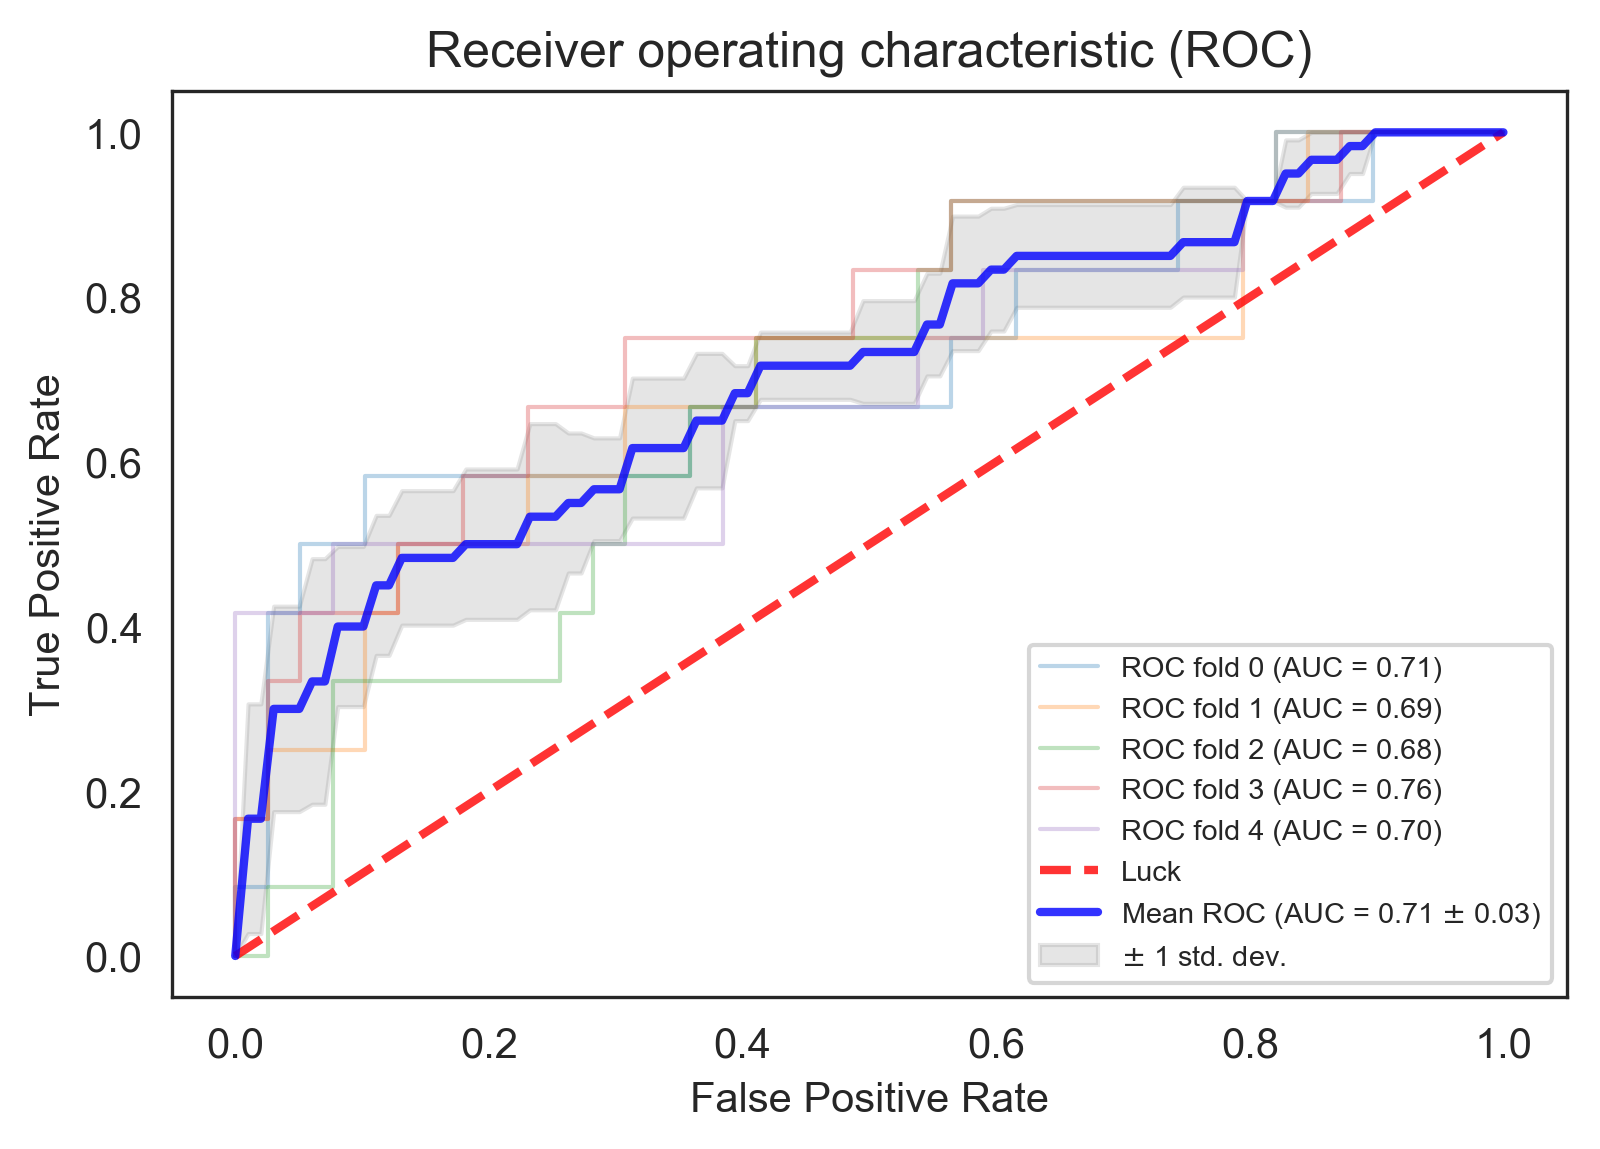

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

 95%CI: [0.63 - 0.76]
SD =  0.039874935375007595


/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 254 + 1) instead
  if __name__ == '__main__':
/Users/hcc/anaconda3/lib/python3.6/site-

(0.6318518518518518, 0.764973544973545)

In [124]:
model,mean_auc,y_true,y_pred = model_training(X,Y,clf,5)
CI_ROC (y_true,y_pred)

In [125]:
df = pd.read_csv('/Users/hcc/Desktop/guizhoushengyi/8.28-hefenji/cli_rad/C_yTrain_true_pred_cli.csv',index_col=0,encoding='gbk')
y_true=df.iloc[:,0]
y_pred=df.iloc[:,1]
matrix_report(y_true,y_pred)

[[147  48]
 [ 27  33]]
sensitivity =  0.7538461538461538
specificity =  0.55
precision =  0.7058823529411765
